In [139]:
%matplotlib notebook
import serial
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.path import Path
from time import time
from scipy.signal import argrelextrema
from scipy import signal

ser = serial.Serial('COM7', 115200)
# set plot to animated
plt.ion()

In [140]:
Wn = 0.05
b, a = signal.butter(3, Wn)
zi = signal.lfilter_zi(b, a)

<IPython.core.display.Javascript object>


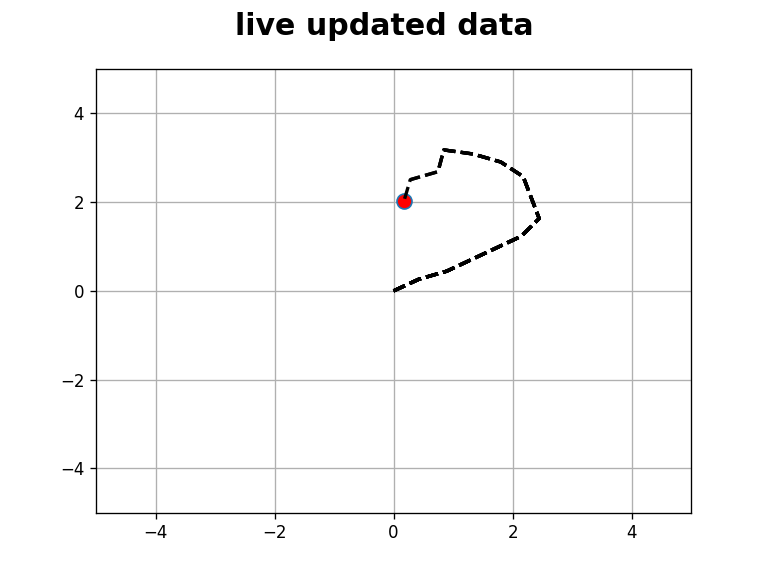

calibrating
do not move
do not move
do not move
do not move
do not move
do not move
do not move
do not move
do not move
do not move
do not move
do not move
do not move
do not move
do not move
do not move
-2023.375
1925.0
calibrating done
[ 11.375 -17.625 -11.625  -9.625  -6.625 -23.625 -44.625  58.375]
Steps: 0
[ -16.625   39.375   66.375  141.375  134.375   71.375  143.375  189.375]
Steps: 0
[  75.375   70.375   60.375  209.375  270.375  405.375  516.375  817.375]
Steps: 0
[  781.375   480.375  1195.375   689.375   332.375  -206.625   718.375
  1133.375]
Steps: 1
1262.0
1
[  894.375   110.375   778.375  1149.375   768.375   388.375  -510.625
  1153.375]
Steps: 1
816.0
1
[ 305.375  582.375  442.375 -329.625  577.375  246.375  674.375  279.375]
Steps: 3
620.0
1
-321.0
1
307.0
1
[-1044.625   935.375   462.375   386.375  -457.625  -328.625   425.375
   580.375]
Steps: 1
919.0
1
[-498.625 -779.625 -147.625  781.375  520.375 -867.625  658.375  612.375]
Steps: 2
223.0
1
591.0
1
[  679.375  -

<IPython.core.display.Javascript object>


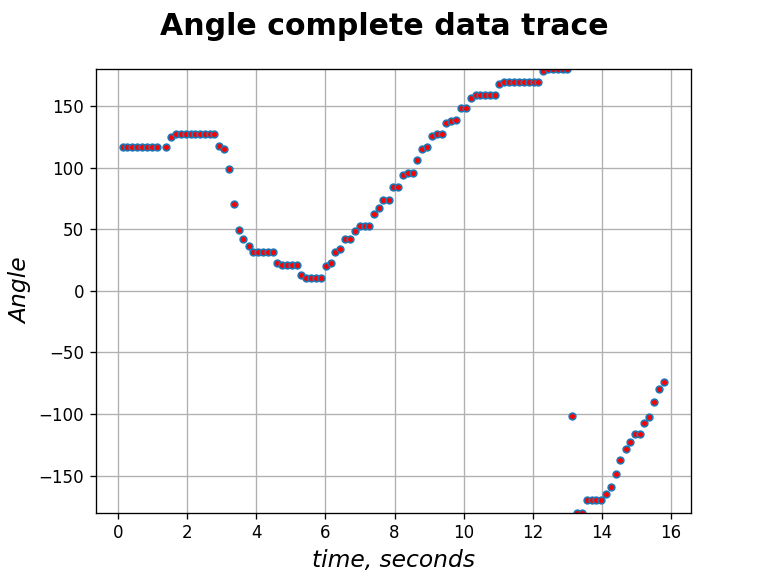

<IPython.core.display.Javascript object>


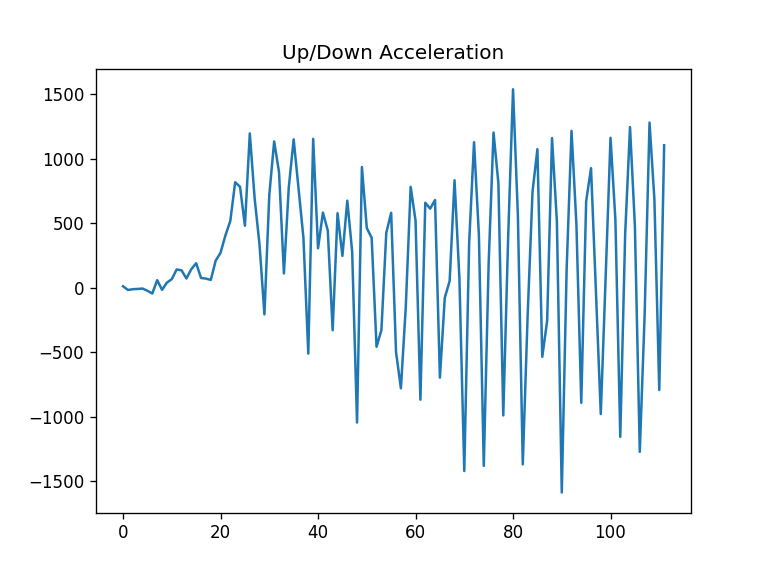

<IPython.core.display.Javascript object>


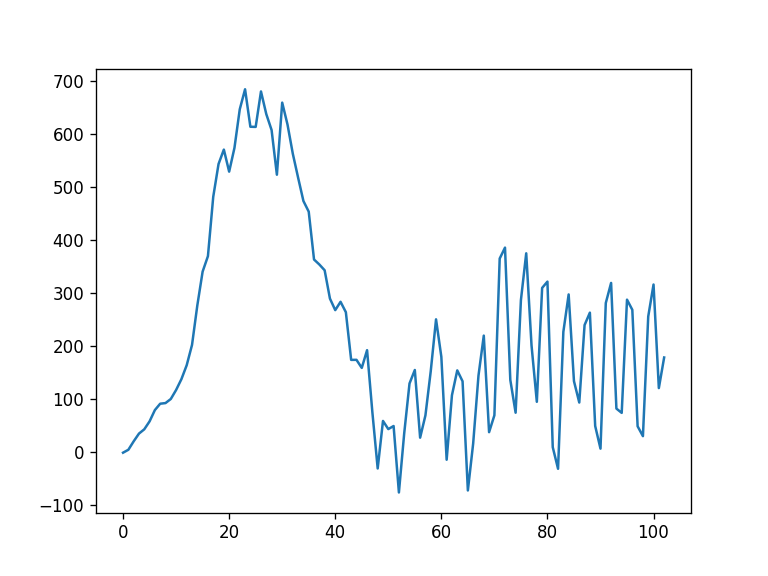

Total steps: 15
Total displacement: 2.02610217436


<IPython.core.display.Javascript object>


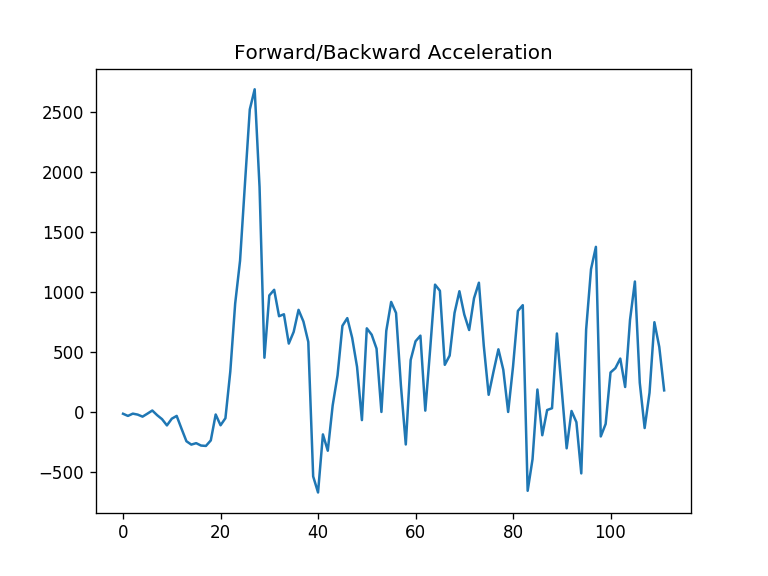

In [141]:
start_time = time()
timepoints = []
accel = []
accelfor = []
angle =[]
x = 0
y = 0
mrange = [-5, 5] #map range
yrange = [-180,180]
view_time = 1 # seconds of data to view at once
duration = 15 # total seconds to collect data
ind = 0
# Values to trigger a step and forward movement
steplim = 200
forlim = 100

# Store Location
verts = [(0,0)]

fig1 = plt.figure()
fig1.suptitle('live updated data', fontsize='18', fontweight='bold')
#plt.xlabel('time, seconds', fontsize='14', fontstyle='italic')
#plt.ylabel('potential, volts', fontsize='14', fontstyle='italic')
plt.axes().grid(True)
line1, = plt.plot(accel,marker='o',markersize=9,linestyle='none',markerfacecolor='red')
ax = fig1.add_subplot(111)
plt.ylim(mrange)
plt.xlim(mrange)

#fig = plt.figure()
#path = Path([(0.,0.)], [Path.MOVETO])
#pathbeg = (0.,0.)
#plt.show

calib_tim = 20
# correction offset
accelcor = 0  
accelforcor = 0
i = 0
print('calibrating')
while (time() < start_time + calib_tim):
    #just read data to get calibration moving
    ser.reset_input_buffer()
    data = ser.readline()
    
    if (time() > start_time + calib_tim - 2):
        print('do not move')
        data = data.decode().split()
        accelcor = accelcor + float(data[1])
        accelforcor = accelforcor + float(data[2])
        i = i + 1    

accelcor = accelcor/i
accelforcor = accelforcor/i
print(accelcor)
print(accelforcor)

print('calibrating done')
start_time = time()

run =  True
# collect the data and plot a moving frame
while run:
    run2 = True
    #start2 = time()
    startind = ind
    #print(time())
    
    iloop = 0
    # Loop to get a chunk of data to later process
    while run2:
        
        ser.reset_input_buffer()
        data = ser.readline()
        data = data.decode().split()
        #print(data)

        #reject if data is cut off
        #try:
        #    if (len(data[0]) < 2):
        #        #((len(data[0]) < 2) or (len(data[1]) < 3)):
        #        #(len(data[1]) < 3):
        #        #print('bad val')
        #        #print(data)
        #        continue
        #    #print(data)
        #except IndexError:
        #    continue
        
        try:
            # store the entire dataset for later
            accel.append(float(data[1]) - accelcor) #acceleration up/down
            angle.append(float(data[0])*360/306) #angle
            accelfor.append(float(data[2]) - accelforcor) # acceleration forward/backward
            timepoints.append(time()-start_time)
            current_time = timepoints[-1]

            # update the plotted data
            #line1.set_xdata(timepoints)
            #line1.set_ydata(accel)

            # slide the viewing frame along
            #if current_time > view_time:
            #    plt.xlim([current_time-view_time,current_time])
            
            iloop = iloop + 1

            # when time's up, kill the collect+plot loop
            if timepoints[-1] > duration: run=False
            if iloop > 7: run2 = False

        # if the try statement throws an error, just do nothing
        except: pass

        # update the plot
        #fig1.canvas.draw()
        ind = ind + 1
   
    # Acceleration Peaks
    # determine the indices of the local maxima
    accelframe = np.array(accel[startind:ind])
    accelforframe = np.array(accelfor[startind:ind])
    print(accelframe)
    maxInd = np.array(argrelextrema(accelframe, np.greater)[0])
    
    # get the actual values using these indices
    peaks = accelframe[maxInd]  # array([5, 3, 6]) peak moving average accel values
    stepind = np.nonzero(peaks > steplim)[0] # index of local maxima that are higher than 500
    stepsamp = maxInd[stepind]  # index of whole sample vector where step occurs
    peaks = peaks[stepind]      
    stepsize = 0.5 
    step = peaks.shape[0]
    dist = step* stepsize # number of estimated steps times distance of 1 step
    #print(dist)
    #print(cumsum_vec)
    print('Steps: ' + str(step))
    
    # Forward Backward Angle
                   
    # polar to cartesian coordinates
#    print(stepsamp.shape)
#    print(stepsamp)
#    print(type(stepsamp[0]))
#    print(len(angle))
    for samp in stepsamp:
        
        # Find whether step was forward/backward or in place
        # forward acceleration at moment of step, we move our bodies 2 samples before we move up
        stepfor = accelforframe[samp-2] 
        if (stepfor > forlim): direction = 1 
        elif (stepfor < -forlim+50): direction = -1
        else: direction = 0
        direction = 1
        print(stepfor)
        print(direction)
            
        # take angle and find distance for each step
        anglestep = angle[samp + startind]
        #print('Angle: ' + str(anglestep))
        x = direction*stepsize*np.cos(np.deg2rad(anglestep)) + x
        y = direction*stepsize*np.sin(np.deg2rad(anglestep)) + y
    
    #print('%f %f'%(x,y))
    line1.set_xdata(x)
    line1.set_ydata(y)
    #fig1.canvas.draw()
    
    verts.append((x,y))
    xs, ys = zip(*verts)
    ax.plot(xs, ys, '--', lw=2, color='black', ms=10)
    fig1.canvas.draw()
    



    
fig2 = plt.figure()
fig2.suptitle('Angle complete data trace', fontsize='18', fontweight='bold')
plt.xlabel('time, seconds', fontsize='14', fontstyle='italic')
plt.ylabel('Angle', fontsize='14', fontstyle='italic')
plt.axes().grid(True)

plt.plot(timepoints, angle,marker='o',markersize=4,linestyle='none',markerfacecolor='red')
plt.ylim(yrange)
fig2.show()

plt.figure()
plt.plot(accel)
plt.title('Up/Down Acceleration')
plt.figure()
window_width = 10
z, _ = signal.lfilter(b, a, accel, zi=zi*accel[0])
                                      
cumsum_vec = np.cumsum(np.insert(accel, 0, 0)) 
ma_vec = (cumsum_vec[window_width:] - cumsum_vec[:-window_width]) / window_width
plt.plot(ma_vec)


# determine the indices of the local maxima
maxInd = np.array(argrelextrema(ma_vec, np.greater)[0])

# get the actual values using these indices
r = ma_vec[maxInd]  # array([5, 3, 6])
stepind = np.nonzero(r > steplim)[0] # index of local maxima that are higher than 500
stepsamp = maxInd[stepind]
r = r[stepind]
stepsize = 0.5 
step = r.shape[0]
disp = np.sqrt(x**2+y**2) # number of estimated steps times distance of 1 step
print('Total steps: ' + str(step))
print('Total displacement: ' + str(disp))

plt.figure()
plt.title('Forward/Backward Acceleration')
plt.plot(accelfor)
#plt.figure()
#window_width = 10

#cumsum_vec = np.cumsum(np.insert(accelfor, 0, 0)) 
#ma_vec = (cumsum_vec[window_width:] - cumsum_vec[:-window_width]) / window_width
#plt.plot(ma_vec)


ser.close()

In [135]:
ser.close()